# Deep Clustering: K-means for landscape clustering 

In [1]:
import cv2
import tensorflow as tf
import random
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_USERNAME'] = "xxxxx"                 #Manually input from kaggle
os.environ['KAGGLE_KEY'] = "xxxxx"   #Manually input from kaggle

api = KaggleApi()
api.authenticate()


api.dataset_download_files('arnaud58/landscape-pictures', path="./Images/", unzip=True)
del api

In [4]:
paths = [path for path in glob.glob("Images/" + "/*.jpg")]
random.Random(0).shuffle(paths)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten

base_model = tf.keras.applications.ResNet101(
    include_top = False, 
    weights = "imagenet",
    input_shape=(224,224,3)
)

model = Sequential([
    base_model,
    Flatten()
])

In [6]:
def get_convolutional_features(img_path: str) -> np.array:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))

    return model.predict( np.array([img]) , verbose = 0)

In [7]:
features, labels = [],[]

for path in paths[:int(len(paths))]:
    features.append( get_convolutional_features(path) )
    labels.append(path)

features = np.array(features)[:,0,:]
labels = np.array(labels)
print("Done!")

Done!


#### K-MEANS

In [12]:
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance

kmeans = KMeansClusterer(num_means = 5 , distance=cosine_distance)
cluster =  kmeans.cluster(features, assign_clusters=True)

In [13]:
groups = []

for centroid in kmeans.means():
    dist = np.array([cosine_distance(centroid, feature) for feature in features])
    min_dists = dist.argsort()[:5]
    groups.append(labels[min_dists])

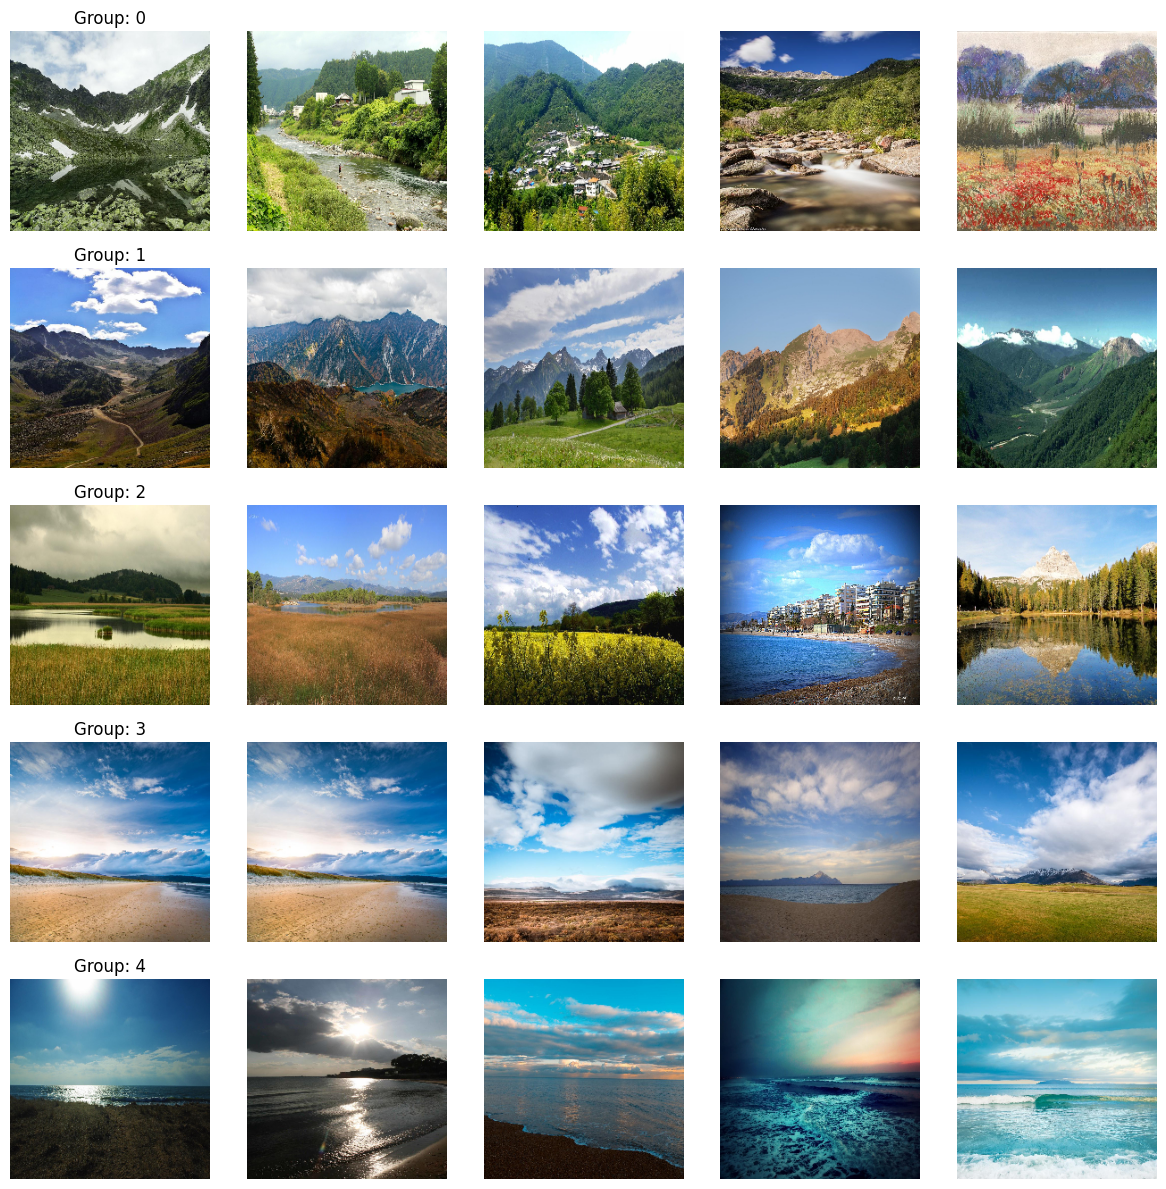

In [14]:
fig, axs = plt.subplots(5, 5, figsize=(12,12))

for i,cluster in enumerate(groups):
    for j, path in enumerate(cluster):
        img = cv2.imread(path)
        img = cv2.resize(img,(224,224))

        axs[i][j].imshow( cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
        axs[i][j].axis('off')

        if j == 0:
            axs[i][j].set_title('Group: {}'.format(i))
    

plt.tight_layout()
plt.show()